# Installing Libraries

In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import shutil

import os
HOME = os.getcwd()
print(HOME)

/kaggle/working


# Installing YOLOv5

In [2]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16941, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 16941 (delta 68), reused 91 (delta 50), pack-reused 16805 (from 1)
Receiving objects: 100% (16941/16941), 15.70 MiB | 25.68 MiB/s, done.
Resolving deltas: 100% (11601/11601), done.
/kaggle/working/yolov5


In [3]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 720.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.0/872.0 kB 28.5 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pointpats 2.5.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.1 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.9.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.0 which is incompatible.


# Data Preprocessing

In [4]:
train_img = '/kaggle/input/car-object-detection/data/training_images'
test_img = '/kaggle/input/car-object-detection/data/testing_images'
train_csv = '/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv'
test_csv = '/kaggle/input/car-object-detection/data/sample_submission.csv'

## Making Images and Labels 

We need to create separate directories for images and labels. The 'images' directory will have our training, validation, and testing images.  The 'labels' directory will contain the bounding box coordinates for each object in the images, stored in YOLOv5 compatible .txt files.

In [5]:
images_dir = '/kaggle/working/images'
os.makedirs(images_dir, exist_ok=True)
os.makedirs(os.path.join(images_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(images_dir, 'val'), exist_ok=True)

labels_dir = '/kaggle/working/labels' 
os.makedirs(labels_dir, exist_ok=True)
os.makedirs(os.path.join(labels_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(labels_dir, 'val'), exist_ok=True)

In [6]:
def convert_to_yolo(row, image_width, image_height):
    class_id = 0 
    x_center = (row['xmin'] + row['xmax']) / 2 / image_width
    y_center = (row['ymin'] + row['ymax']) / 2 / image_height
    width = (row['xmax'] - row['xmin']) / image_width
    height = (row['ymax'] - row['ymin']) / image_height
    return f"{class_id} {x_center} {y_center} {width} {height}"

In [7]:
df = pd.read_csv(train_csv)
df.columns = ['image', 'xmin', 'ymin', 'xmax', 'ymax']
df = df.dropna(subset=['image']).fillna(method='ffill')

/tmp/ipykernel_23/3033771076.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.dropna(subset=['image']).fillna(method='ffill')


In [8]:
train_images, val_images = train_test_split(df['image'].unique(), test_size=0.2, random_state=42)

In [9]:
import cv2
for image_name in df['image'].unique():
    image_path = os.path.join(train_img, image_name)

    try:
        img = cv2.imread(image_path) 
        if img is None:
            raise FileNotFoundError(f"Image not found or could not be opened: {image_path}")
        image_height, image_width, _ = img.shape  
    except FileNotFoundError as e:
        print(f"Error processing {image_name}: {e}")
        continue 

    group = df[df['image'] == image_name]

    label_subdir = 'train' if image_name in train_images else 'val'
    image_subdir = label_subdir

    label_path = os.path.join(labels_dir, label_subdir, os.path.splitext(image_name)[0] + '.txt')

    with open(label_path, 'w') as f:
        for _, row in group.iterrows():
            yolo_line = convert_to_yolo(row, image_width, image_height)
            f.write(yolo_line + '\n')

    shutil.copy(image_path, os.path.join(images_dir, image_subdir, image_name))

## The data.yaml File

In [10]:
data_yaml = '/kaggle/working/data.yaml'
with open(data_yaml, 'w') as f:
    f.write(f"""
train: /kaggle/working/images/train 
val: /kaggle/working/images/val     
test: {test_img}

nc: 1 
names: ['car']
 
""")

# Training Model

In [11]:
%cd {HOME}
!python /kaggle/working/yolov5/train.py --img 416 --batch 16 --epochs 30 --data /kaggle/working/data.yaml --cfg yolov5s.yaml --weights 'yolov5s.pt' --cache

/kaggle/working
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=/kaggle/working/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5/data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, uploa

# Applying Model on Test Images

In [12]:
%cd {HOME}
!python /kaggle/working/yolov5/detect.py --source /kaggle/input/car-object-detection/data/testing_images  --weights /kaggle/working/yolov5/runs/train/exp/weights/best.pt --img 416 --conf 0.5

/kaggle/working
detect: weights=['/kaggle/working/yolov5/runs/train/exp/weights/best.pt'], source=/kaggle/input/car-object-detection/data/testing_images, data=yolov5/data/coco128.yaml, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-363-gf44db010 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25100.jpg: 256x416 (no detections), 29.0ms
image 2/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25120.jpg: 256x416 (no detections), 6.5ms


# Random Sample Detections

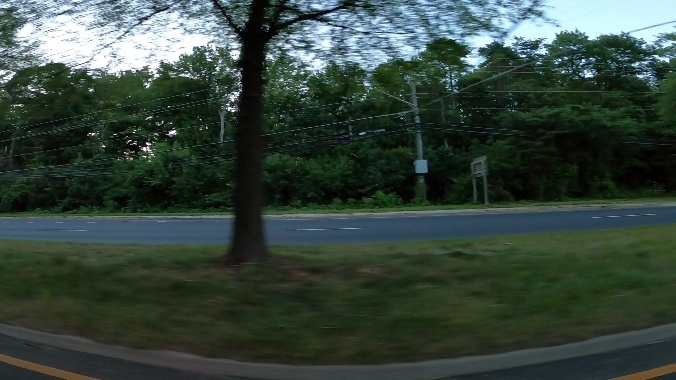

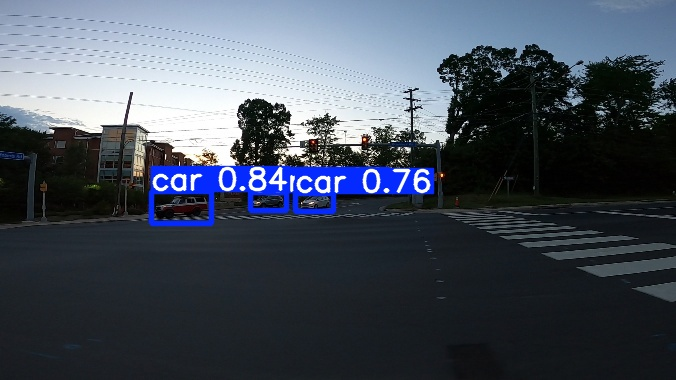

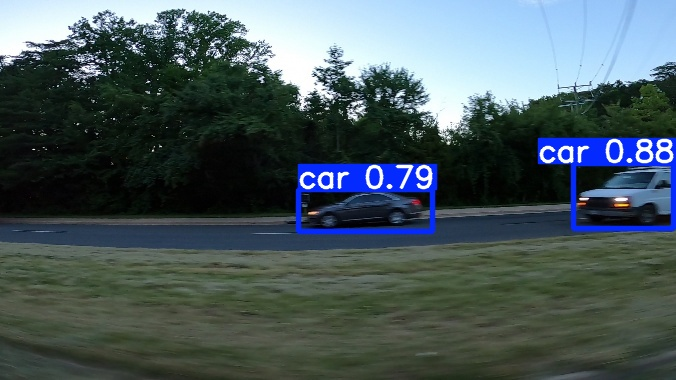

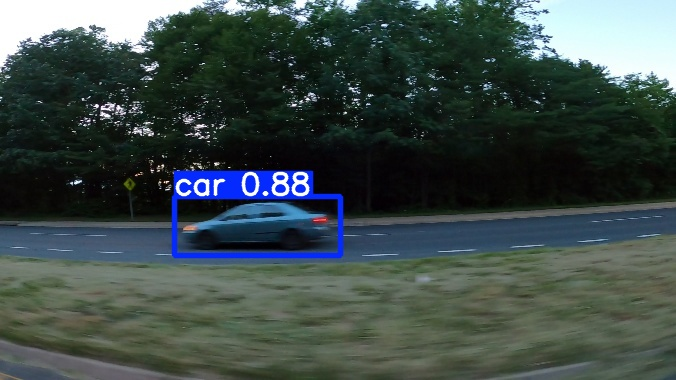

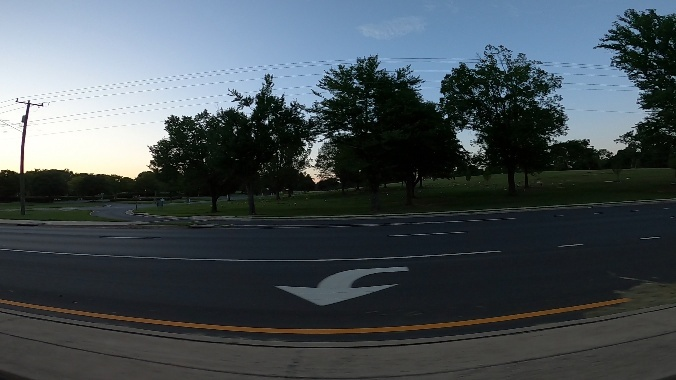

In [13]:
from IPython.display import Image,display
import random

results_dir = '/kaggle/working/yolov5/runs/detect/exp'
all_image_files = [f for f in os.listdir(results_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

random_images = random.sample(all_image_files, 5) 
image_paths = [os.path.join(results_dir, img) for img in random_images]

for path in image_paths:
    display(Image(filename=path, width=500))